In [1]:
import sys
import os
sys.path.append(os.path.abspath('..'))

In [2]:
import torch
import torch.optim as optim
from model import LogisticRegressionModule
from data import get_dataloaders
from l2d_functionality.l2d_loss import L2D_Loss
from l2d_functionality.l2d_eval import L2D_Eval
import numpy as np
import matplotlib.pyplot as plt

Define standard hyperparameters, including number of classes (`num_classes`). `l2_lambda` is a regularization parameter used in the standard classifier, and `expert_prob` is used to generate expert labels, affecting the accuracy of a simulated expert.

In [3]:
input_dim = 28 * 28
num_classes = 10
learning_rate = 0.00005
num_epochs = 5
l2_lambda = 0.5
expert_prob = 0.9

Include an extra dimension for the deferral class.

In [4]:
output_dim = num_classes + 1
deferral_class_index = num_classes

Load the MNIST dataset, separating the train from the test sets. Simulate an expert and their labels via the ExpertMNIST class.

In [5]:
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms as transforms
from data import ExpertMNIST

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)),
    transforms.Lambda(lambda tensor: torch.flatten(tensor)) # Flatten the tensor
])

train_dataset_raw = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset_raw = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

expert = ExpertMNIST(expert_prob)

expert_labels_train = torch.tensor([expert.expert_prediction(label) for _, label in train_dataset_raw])
expert_labels_test = torch.tensor([expert.expert_prediction(label) for _, label in test_dataset_raw])

Instantiate the classifier - here, you can pass in any PyTorch model, providing the `output_dim` accounts for the deferral dimension as noted earlier. Get the DataLoaders, merging the data with the generated expert labels. 

In [6]:
model = LogisticRegressionModule(input_dim, output_dim, deferral_class_index, l2_lambda)
train_loader, test_loader = get_dataloaders(train_dataset_raw, expert_labels_train, test_dataset_raw, expert_labels_test)

Here, the possible parametrization types are listed for convenience.

In [7]:
# param_type = "softmax"
# param_type = "one_vs_all"
# param_type = "asymmetric_sm"
# param_type = "realizable_sm"

Run the training loop. L2D_Loss provides the loss function, with your specified parametrization type. 

In [8]:
l2d = L2D_Loss(num_classes)

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
losses = []

for epoch in range(int(num_epochs)):

    for images, labels, expert_labels_batch in train_loader:
        outputs = model(images)
        
        loss = l2d.loss_fn(outputs, labels, expert_labels_batch, deferral_class_index, "asymmetric_sm")

        loss += model.l2_regularization()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        losses.append(loss.item())


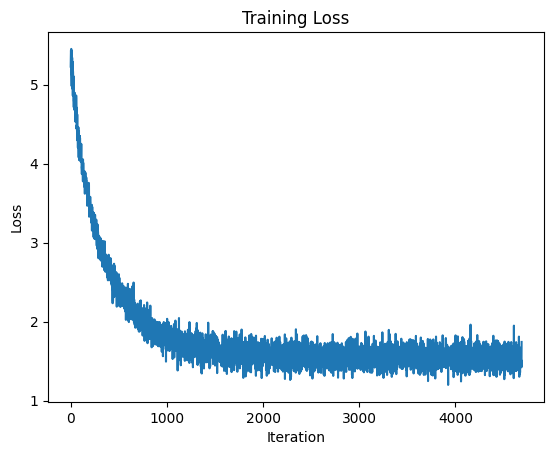

In [9]:
plt.plot(losses)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.savefig("training_loss.png")

Evaluate the model. Since Learning-to-Defer has extra functionality on deferral, the L2D_Eval class provides additional evaluation functionality including statistics on the accuracy of the regular classifier (with no L2D), accuracy of the classifier on the part of the data that was not deferred, deferral accuracy, percentage of data deferred, and overall accuracy with L2D. It also provides class-wise metrics and a function to visualize the per-class metrics. 

Test Accuracy of Regular Classifier: 86.85%
Test Accuracy (excluding deferrals): 91.91%
Deferral Accuracy: 76.42%
Overall Deferral Rate: 46.87%
Overall L2D Accuracy: 84.65%
Class 0: Accuracy (non-deferred) = 98.06%, Deferral Rate = 5.20%, Overall Accuracy = 92.96%
Class 1: Accuracy (non-deferred) = 96.94%, Deferral Rate = 59.65%, Overall Accuracy = 93.66%
Class 2: Accuracy (non-deferred) = 86.48%, Deferral Rate = 13.28%, Overall Accuracy = 75.00%
Class 3: Accuracy (non-deferred) = 91.74%, Deferral Rate = 77.23%, Overall Accuracy = 92.08%
Class 4: Accuracy (non-deferred) = 94.16%, Deferral Rate = 28.51%, Overall Accuracy = 67.31%
Class 5: Accuracy (non-deferred) = 75.38%, Deferral Rate = 70.85%, Overall Accuracy = 89.13%
Class 6: Accuracy (non-deferred) = 94.79%, Deferral Rate = 3.86%, Overall Accuracy = 91.13%
Class 7: Accuracy (non-deferred) = 83.67%, Deferral Rate = 90.47%, Overall Accuracy = 95.91%
Class 8: Accuracy (non-deferred) = 90.47%, Deferral Rate = 42.92%, Overall Accuracy =

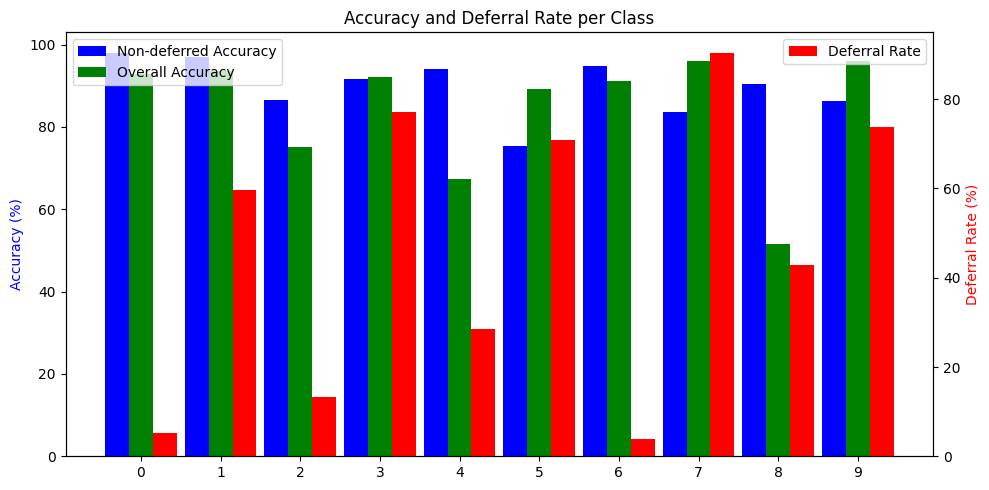

In [10]:
all_outputs = []
all_labels = []
all_expert_labels = []

with torch.no_grad():
    for images, labels, expert_labels in test_loader:

        outputs = model(images)
        all_outputs.append(outputs)
        all_labels.append(labels)
        all_expert_labels.append(expert_labels)

all_outputs = torch.cat(all_outputs, dim=0)
all_labels = torch.cat(all_labels, dim=0)
all_expert_labels = torch.cat(all_expert_labels, dim=0)

l2d_eval = L2D_Eval(num_classes, all_outputs, all_labels, all_expert_labels, deferral_class_index)

model_report = l2d_eval.model_report()
per_class_report = l2d_eval.per_class_report()
l2d_eval.visualize_per_class_metrics()

In [11]:
print(model_report)

{'Test Accuracy of Regular Classifier': 86.85, 'Test Accuracy (excluding deferrals)': 91.90664408055713, 'Deferral Accuracy': 76.42415190953702, 'Overall Deferral Rate': 46.87, 'Overall L2D Accuracy': 84.65}


In [12]:
print(per_class_report)

{0: {'accuracy_nondeferred': 98.06243272335846, 'deferral_rate': 5.204081632653061, 'overall_accuracy': 92.95918367346938}, 1: {'accuracy_nondeferred': 96.94323144104804, 'deferral_rate': 59.647577092511014, 'overall_accuracy': 93.65638766519824}, 2: {'accuracy_nondeferred': 86.4804469273743, 'deferral_rate': 13.275193798449612, 'overall_accuracy': 75.0}, 3: {'accuracy_nondeferred': 91.73913043478261, 'deferral_rate': 77.22772277227723, 'overall_accuracy': 92.07920792079207}, 4: {'accuracy_nondeferred': 94.15954415954415, 'deferral_rate': 28.513238289205702, 'overall_accuracy': 67.31160896130346}, 5: {'accuracy_nondeferred': 75.38461538461539, 'deferral_rate': 70.85201793721973, 'overall_accuracy': 89.12556053811659}, 6: {'accuracy_nondeferred': 94.78827361563518, 'deferral_rate': 3.862212943632568, 'overall_accuracy': 91.12734864300626}, 7: {'accuracy_nondeferred': 83.6734693877551, 'deferral_rate': 90.46692607003891, 'overall_accuracy': 95.91439688715953}, 8: {'accuracy_nondeferred':